## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [9]:
# 載入 Callbacks


optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.5, 0.9 ]
reduce_lr_patient = [1, 5 , 15, 25]

In [10]:
from keras.callbacks import ReduceLROnPlateau
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, reduce_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 1
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
______________________________________________________________

49/49 [==============================] - 4s 73ms/step - loss: 3.0174 - accuracy: 0.1058 - val_loss: 2.4148 - val_accuracy: 0.0975
Epoch 3/25
49/49 [==============================] - 3s 70ms/step - loss: 3.0168 - accuracy: 0.1074 - val_loss: 2.4844 - val_accuracy: 0.0997
Epoch 4/25
49/49 [==============================] - 4s 72ms/step - loss: 3.0178 - accuracy: 0.1057 - val_loss: 2.5486 - val_accuracy: 0.0995
Epoch 5/25
49/49 [==============================] - 4s 72ms/step - loss: 3.0169 - accuracy: 0.1061 - val_loss: 2.6064 - val_accuracy: 0.1019
Epoch 6/25
49/49 [==============================] - ETA: 0s - loss: 3.0180 - accuracy: 0.1061
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1e-12.
49/49 [==============================] - 4s 73ms/step - loss: 3.0180 - accuracy: 0.1061 - val_loss: 2.6622 - val_accuracy: 0.1039
Epoch 7/25
49/49 [==============================] - 4s 73ms/step - loss: 3.0175 - accuracy: 0.1065 - val_loss: 2.7175 - val_accuracy: 0.1012
Epoch 8/25
49/49 [

49/49 [==============================] - 4s 72ms/step - loss: 3.1521 - accuracy: 0.0849 - val_loss: 3.1562 - val_accuracy: 0.0835
Epoch 24/25
49/49 [==============================] - 3s 71ms/step - loss: 3.1534 - accuracy: 0.0846 - val_loss: 3.1567 - val_accuracy: 0.0835
Epoch 25/25
49/49 [==============================] - 4s 74ms/step - loss: 3.1517 - accuracy: 0.0839 - val_loss: 3.1569 - val_accuracy: 0.0834
Numbers of exp: 3, reduce_factor: 0.10, reduce_patient: 25
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
___________________________________________

49/49 [==============================] - 4s 75ms/step - loss: 3.1753 - accuracy: 0.0851 - val_loss: 3.0281 - val_accuracy: 0.0792
Epoch 11/25
49/49 [==============================] - 4s 73ms/step - loss: 3.1748 - accuracy: 0.0853 - val_loss: 3.0706 - val_accuracy: 0.0786
Epoch 12/25
49/49 [==============================] - 4s 73ms/step - loss: 3.1743 - accuracy: 0.0856 - val_loss: 3.1040 - val_accuracy: 0.0793
Epoch 13/25
49/49 [==============================] - 4s 73ms/step - loss: 3.1752 - accuracy: 0.0855 - val_loss: 3.1294 - val_accuracy: 0.0806
Epoch 14/25
49/49 [==============================] - 4s 74ms/step - loss: 3.1747 - accuracy: 0.0850 - val_loss: 3.1482 - val_accuracy: 0.0805
Epoch 15/25
49/49 [==============================] - 4s 74ms/step - loss: 3.1746 - accuracy: 0.0848 - val_loss: 3.1618 - val_accuracy: 0.0797
Epoch 16/25
49/49 [==============================] - 4s 74ms/step - loss: 3.1747 - accuracy: 0.0861 - val_loss: 3.1712 - val_accuracy: 0.0793
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 4s 76ms/step - loss: 2.9202 - accuracy: 0.1224 - val_loss: 2.3005 - val_accuracy: 0.1354
Epoch 2/25
49/49 [==============================] - 4s 78ms/step - loss: 2.9189 - accuracy: 0.1229 - val_loss: 2.3478 - val_accuracy: 0.1340
Epoch 3/25
49/49 [==============================] - 4s 75ms/step - loss: 2.9175 - accuracy: 0.1221 - val_loss: 2.4134 - val_accuracy: 0.1303
Epoch 4/25
49/49 [==============================] - 4s 73ms/step - loss: 2.9178 - accuracy: 0.1221 - val_loss: 2.4755 - val_accuracy: 0.1281
Epoch 5/25
49/49 [==============================] - 4s 73ms/step - loss: 2.9190 - accuracy: 0.1225 - val_loss: 2.5334 - val_accuracy: 0.1260
Epoch 6/25
49/49 [==============================] - 4s 74ms/step - loss: 2.9192 - accuracy: 0.1226 - val_loss: 2.5882 - val_accuracy: 0.1208
Epoch 7/25
49/49 [==============================] - 4s 75ms/step - loss: 2.9194 - accuracy: 0.1217 - val_loss: 2.6403 - val_accuracy: 0.1195
Epoch 8/25
49

49/49 [==============================] - 4s 73ms/step - loss: 2.9456 - accuracy: 0.1065 - val_loss: 2.9498 - val_accuracy: 0.1086
Epoch 24/25
49/49 [==============================] - 4s 72ms/step - loss: 2.9468 - accuracy: 0.1056 - val_loss: 2.9501 - val_accuracy: 0.1085
Epoch 25/25
49/49 [==============================] - 4s 73ms/step - loss: 2.9457 - accuracy: 0.1064 - val_loss: 2.9500 - val_accuracy: 0.1086
Numbers of exp: 8, reduce_factor: 0.90, reduce_patient: 1
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_27 (Batc (None, 512)               2048      
___________________________________________

49/49 [==============================] - 4s 74ms/step - loss: 3.0805 - accuracy: 0.0906 - val_loss: 2.9024 - val_accuracy: 0.0926
Epoch 11/25
49/49 [==============================] - 4s 73ms/step - loss: 3.0797 - accuracy: 0.0910 - val_loss: 2.9405 - val_accuracy: 0.0918
Epoch 12/25
49/49 [==============================] - 4s 73ms/step - loss: 3.0801 - accuracy: 0.0908 - val_loss: 2.9722 - val_accuracy: 0.0899
Epoch 13/25
49/49 [==============================] - 4s 72ms/step - loss: 3.0799 - accuracy: 0.0903 - val_loss: 2.9976 - val_accuracy: 0.0904
Epoch 14/25
49/49 [==============================] - 4s 73ms/step - loss: 3.0799 - accuracy: 0.0900 - val_loss: 3.0174 - val_accuracy: 0.0915
Epoch 15/25
49/49 [==============================] - 4s 74ms/step - loss: 3.0804 - accuracy: 0.0901 - val_loss: 3.0323 - val_accuracy: 0.0911
Epoch 16/25
49/49 [==============================] - 4s 74ms/step - loss: 3.0815 - accuracy: 0.0900 - val_loss: 3.0428 - val_accuracy: 0.0909
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 4s 81ms/step - loss: 3.0804 - accuracy: 0.0989 - val_loss: 2.3626 - val_accuracy: 0.0839
Epoch 2/25
49/49 [==============================] - 4s 75ms/step - loss: 3.0812 - accuracy: 0.0980 - val_loss: 2.3972 - val_accuracy: 0.1002
Epoch 3/25
49/49 [==============================] - 4s 75ms/step - loss: 3.0813 - accuracy: 0.0976 - val_loss: 2.4623 - val_accuracy: 0.1099
Epoch 4/25
49/49 [==============================] - 4s 75ms/step - loss: 3.0816 - accuracy: 0.0987 - val_loss: 2.5357 - val_accuracy: 0.1105
Epoch 5/25
49/49 [==============================] - 4s 75ms/step - loss: 3.0801 - accuracy: 0.0984 - val_loss: 2.6074 - val_accuracy: 0.1105
Epoch 6/25
49/49 [==============================] - 4s 75ms/step - loss: 3.0815 - accuracy: 0.0984 - val_loss: 2.6755 - val_accuracy: 0.1081
Epoch 7/25
49/49 [==============================] - 4s 76ms/step - loss: 3.0807 - accuracy: 0.0989 - val_loss: 2.7394 - val_accuracy: 0.1043
Epoch 8/25
49

Epoch 18/25
49/49 [==============================] - ETA: 0s - loss: 1.0398 - accuracy: 0.6436
Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
49/49 [==============================] - 5s 92ms/step - loss: 1.0398 - accuracy: 0.6436 - val_loss: 1.3172 - val_accuracy: 0.5332
Epoch 19/25
49/49 [==============================] - ETA: 0s - loss: 1.0405 - accuracy: 0.6431
Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
49/49 [==============================] - 7s 133ms/step - loss: 1.0405 - accuracy: 0.6431 - val_loss: 1.3174 - val_accuracy: 0.5338
Epoch 20/25
49/49 [==============================] - ETA: 0s - loss: 1.0403 - accuracy: 0.6432
Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
49/49 [==============================] - 5s 100ms/step - loss: 1.0403 - accuracy: 0.6432 - val_loss: 1.3175 - val_accuracy: 0.5339
Epoch 21/25
49/49 [==============================] - ETA: 0s - loss: 1.0404 - accur

Epoch 1/25
49/49 [==============================] - 4s 80ms/step - loss: 3.0324 - accuracy: 0.0988 - val_loss: 2.3362 - val_accuracy: 0.1150
Epoch 2/25
49/49 [==============================] - 4s 73ms/step - loss: 3.0310 - accuracy: 0.0996 - val_loss: 2.3828 - val_accuracy: 0.1176
Epoch 3/25
49/49 [==============================] - 4s 77ms/step - loss: 3.0298 - accuracy: 0.0985 - val_loss: 2.4318 - val_accuracy: 0.1165
Epoch 4/25
49/49 [==============================] - 4s 76ms/step - loss: 3.0310 - accuracy: 0.0992 - val_loss: 2.4855 - val_accuracy: 0.1146
Epoch 5/25
49/49 [==============================] - 4s 75ms/step - loss: 3.0304 - accuracy: 0.0985 - val_loss: 2.5471 - val_accuracy: 0.1098
Epoch 6/25
49/49 [==============================] - 4s 86ms/step - loss: 3.0312 - accuracy: 0.0990 - val_loss: 2.6132 - val_accuracy: 0.1084
Epoch 7/25
49/49 [==============================] - 4s 78ms/step - loss: 3.0311 - accuracy: 0.0984 - val_loss: 2.6797 - val_accuracy: 0.1053
Epoch 8/25
49

49/49 [==============================] - 4s 78ms/step - loss: 3.0333 - accuracy: 0.0973 - val_loss: 3.0360 - val_accuracy: 0.0960
Epoch 24/25
49/49 [==============================] - 4s 78ms/step - loss: 3.0339 - accuracy: 0.0966 - val_loss: 3.0363 - val_accuracy: 0.0960
Epoch 25/25
49/49 [==============================] - 4s 75ms/step - loss: 3.0335 - accuracy: 0.0964 - val_loss: 3.0364 - val_accuracy: 0.0959
Numbers of exp: 16, reduce_factor: 0.50, reduce_patient: 1
Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_51 (Batc (None, 512)               2048      
__________________________________________

49/49 [==============================] - 4s 76ms/step - loss: 3.0266 - accuracy: 0.1089 - val_loss: 2.8639 - val_accuracy: 0.1106
Epoch 11/25
49/49 [==============================] - 4s 91ms/step - loss: 3.0272 - accuracy: 0.1097 - val_loss: 2.9031 - val_accuracy: 0.1101
Epoch 12/25
49/49 [==============================] - 4s 86ms/step - loss: 3.0273 - accuracy: 0.1093 - val_loss: 2.9365 - val_accuracy: 0.1098
Epoch 13/25
49/49 [==============================] - 4s 77ms/step - loss: 3.0257 - accuracy: 0.1090 - val_loss: 2.9637 - val_accuracy: 0.1111
Epoch 14/25
49/49 [==============================] - 4s 77ms/step - loss: 3.0267 - accuracy: 0.1095 - val_loss: 2.9852 - val_accuracy: 0.1118
Epoch 15/25
49/49 [==============================] - 4s 75ms/step - loss: 3.0271 - accuracy: 0.1091 - val_loss: 3.0010 - val_accuracy: 0.1118
Epoch 16/25
49/49 [==============================] - 4s 76ms/step - loss: 3.0282 - accuracy: 0.1091 - val_loss: 3.0122 - val_accuracy: 0.1110
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 5s 99ms/step - loss: 3.0286 - accuracy: 0.0937 - val_loss: 2.3363 - val_accuracy: 0.1080
Epoch 2/25
49/49 [==============================] - 4s 75ms/step - loss: 3.0290 - accuracy: 0.0930 - val_loss: 2.3710 - val_accuracy: 0.0967
Epoch 3/25
49/49 [==============================] - 4s 76ms/step - loss: 3.0291 - accuracy: 0.0923 - val_loss: 2.4313 - val_accuracy: 0.0938
Epoch 4/25
49/49 [==============================] - 4s 78ms/step - loss: 3.0296 - accuracy: 0.0936 - val_loss: 2.4990 - val_accuracy: 0.0951
Epoch 5/25
49/49 [==============================] - 4s 76ms/step - loss: 3.0289 - accuracy: 0.0935 - val_loss: 2.5685 - val_accuracy: 0.0938
Epoch 6/25
49/49 [==============================] - 4s 88ms/step - loss: 3.0297 - accuracy: 0.0937 - val_loss: 2.6374 - val_accuracy: 0.0944
Epoch 7/25
49/49 [==============================] - 4s 79ms/step - loss: 3.0289 - accuracy: 0.0929 - val_loss: 2.7027 - val_accuracy: 0.0937
Epoch 8/25
49

49/49 [==============================] - 4s 79ms/step - loss: 3.1440 - accuracy: 0.0893 - val_loss: 3.1406 - val_accuracy: 0.0917
Epoch 24/25
49/49 [==============================] - 4s 78ms/step - loss: 3.1444 - accuracy: 0.0893 - val_loss: 3.1404 - val_accuracy: 0.0915
Epoch 25/25
49/49 [==============================] - 4s 79ms/step - loss: 3.1434 - accuracy: 0.0899 - val_loss: 3.1405 - val_accuracy: 0.0915
Numbers of exp: 21, reduce_factor: 0.90, reduce_patient: 5
Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_66 (Batc (None, 512)               2048      
__________________________________________

49/49 [==============================] - 4s 83ms/step - loss: 3.1403 - accuracy: 0.0951 - val_loss: 2.9767 - val_accuracy: 0.0968
Epoch 11/25
49/49 [==============================] - 4s 81ms/step - loss: 3.1409 - accuracy: 0.0945 - val_loss: 3.0196 - val_accuracy: 0.0963
Epoch 12/25
49/49 [==============================] - 4s 82ms/step - loss: 3.1398 - accuracy: 0.0942 - val_loss: 3.0544 - val_accuracy: 0.0957
Epoch 13/25
49/49 [==============================] - 4s 82ms/step - loss: 3.1396 - accuracy: 0.0955 - val_loss: 3.0813 - val_accuracy: 0.0975
Epoch 14/25
49/49 [==============================] - 4s 81ms/step - loss: 3.1399 - accuracy: 0.0952 - val_loss: 3.1017 - val_accuracy: 0.0976
Epoch 15/25
49/49 [==============================] - 4s 82ms/step - loss: 3.1392 - accuracy: 0.0948 - val_loss: 3.1170 - val_accuracy: 0.0971
Epoch 16/25
49/49 [==============================] - 4s 81ms/step - loss: 3.1394 - accuracy: 0.0945 - val_loss: 3.1275 - val_accuracy: 0.0974
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 5s 93ms/step - loss: 1.7928 - accuracy: 0.3771 - val_loss: 2.4618 - val_accuracy: 0.1868
Epoch 2/25
49/49 [==============================] - 5s 92ms/step - loss: 1.5279 - accuracy: 0.4595 - val_loss: 2.1509 - val_accuracy: 0.2628
Epoch 3/25
49/49 [==============================] - 5s 94ms/step - loss: 1.4268 - accuracy: 0.4933 - val_loss: 1.9023 - val_accuracy: 0.3396
Epoch 4/25
49/49 [==============================] - 5s 94ms/step - loss: 1.3531 - accuracy: 0.5215 - val_loss: 1.8224 - val_accuracy: 0.3443
Epoch 5/25
49/49 [==============================] - ETA: 0s - loss: 1.2927 - accuracy: 0.5432
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
49/49 [==============================] - 5s 94ms/step - loss: 1.2927 - accuracy: 0.5432 - val_loss: 1.9614 - val_accuracy: 0.3254
Epoch 6/25
49/49 [==============================] - 5s 93ms/step - loss: 1.1604 - accuracy: 0.5955 - val_loss: 1.5143 - val_accurac

Epoch 12/25
49/49 [==============================] - 5s 98ms/step - loss: 2.9882 - accuracy: 0.1039 - val_loss: 2.8833 - val_accuracy: 0.1078
Epoch 13/25
49/49 [==============================] - 5s 97ms/step - loss: 2.9873 - accuracy: 0.1042 - val_loss: 2.9086 - val_accuracy: 0.1070
Epoch 14/25
49/49 [==============================] - 5s 101ms/step - loss: 2.9883 - accuracy: 0.1036 - val_loss: 2.9280 - val_accuracy: 0.1056
Epoch 15/25
49/49 [==============================] - 5s 104ms/step - loss: 2.9869 - accuracy: 0.1041 - val_loss: 2.9420 - val_accuracy: 0.1045
Epoch 16/25
49/49 [==============================] - 5s 103ms/step - loss: 2.9876 - accuracy: 0.1039 - val_loss: 2.9517 - val_accuracy: 0.1042
Epoch 17/25
49/49 [==============================] - 5s 98ms/step - loss: 2.9873 - accuracy: 0.1048 - val_loss: 2.9585 - val_accuracy: 0.1048
Epoch 18/25
49/49 [==============================] - 5s 98ms/step - loss: 2.9875 - accuracy: 0.1042 - val_loss: 2.9628 - val_accuracy: 0.1042
Epo

Epoch 1/25
49/49 [==============================] - 5s 97ms/step - loss: 2.9294 - accuracy: 0.1087 - val_loss: 2.3200 - val_accuracy: 0.1281
Epoch 2/25
49/49 [==============================] - 5s 100ms/step - loss: 2.9300 - accuracy: 0.1083 - val_loss: 2.3695 - val_accuracy: 0.1017
Epoch 3/25
49/49 [==============================] - 5s 101ms/step - loss: 2.9292 - accuracy: 0.1085 - val_loss: 2.4219 - val_accuracy: 0.0932
Epoch 4/25
49/49 [==============================] - 5s 101ms/step - loss: 2.9297 - accuracy: 0.1084 - val_loss: 2.4742 - val_accuracy: 0.0940
Epoch 5/25
49/49 [==============================] - 5s 102ms/step - loss: 2.9304 - accuracy: 0.1081 - val_loss: 2.5271 - val_accuracy: 0.0938
Epoch 6/25
49/49 [==============================] - 5s 100ms/step - loss: 2.9290 - accuracy: 0.1077 - val_loss: 2.5805 - val_accuracy: 0.0982
Epoch 7/25
49/49 [==============================] - 5s 100ms/step - loss: 2.9294 - accuracy: 0.1081 - val_loss: 2.6329 - val_accuracy: 0.0982
Epoch 8

49/49 [==============================] - 5s 103ms/step - loss: 2.9985 - accuracy: 0.1063 - val_loss: 2.9987 - val_accuracy: 0.1093
Epoch 24/25
49/49 [==============================] - 5s 103ms/step - loss: 2.9980 - accuracy: 0.1066 - val_loss: 2.9990 - val_accuracy: 0.1092
Epoch 25/25
49/49 [==============================] - 5s 105ms/step - loss: 2.9985 - accuracy: 0.1059 - val_loss: 2.9992 - val_accuracy: 0.1092
Numbers of exp: 29, reduce_factor: 0.50, reduce_patient: 5
Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_90 (Batc (None, 512)               2048      
_______________________________________

Epoch 10/25
49/49 [==============================] - 5s 103ms/step - loss: 3.1451 - accuracy: 0.0796 - val_loss: 2.9969 - val_accuracy: 0.0735
Epoch 11/25
49/49 [==============================] - 5s 105ms/step - loss: 3.1448 - accuracy: 0.0796 - val_loss: 3.0349 - val_accuracy: 0.0735
Epoch 12/25
49/49 [==============================] - 5s 104ms/step - loss: 3.1460 - accuracy: 0.0796 - val_loss: 3.0663 - val_accuracy: 0.0747
Epoch 13/25
49/49 [==============================] - 5s 103ms/step - loss: 3.1456 - accuracy: 0.0797 - val_loss: 3.0917 - val_accuracy: 0.0757
Epoch 14/25
49/49 [==============================] - 5s 108ms/step - loss: 3.1450 - accuracy: 0.0800 - val_loss: 3.1108 - val_accuracy: 0.0767
Epoch 15/25
49/49 [==============================] - 5s 105ms/step - loss: 3.1447 - accuracy: 0.0801 - val_loss: 3.1248 - val_accuracy: 0.0767
Epoch 16/25
49/49 [==============================] - 5s 103ms/step - loss: 3.1448 - accuracy: 0.0797 - val_loss: 3.1348 - val_accuracy: 0.0765

Epoch 1/25
49/49 [==============================] - 6s 116ms/step - loss: 3.1658 - accuracy: 0.0843 - val_loss: 2.3649 - val_accuracy: 0.0927
Epoch 2/25
49/49 [==============================] - 5s 107ms/step - loss: 3.1658 - accuracy: 0.0847 - val_loss: 2.4495 - val_accuracy: 0.0932
Epoch 3/25
49/49 [==============================] - 5s 106ms/step - loss: 3.1658 - accuracy: 0.0843 - val_loss: 2.5384 - val_accuracy: 0.0945
Epoch 4/25
49/49 [==============================] - 5s 105ms/step - loss: 3.1659 - accuracy: 0.0851 - val_loss: 2.6111 - val_accuracy: 0.0916
Epoch 5/25
49/49 [==============================] - 5s 104ms/step - loss: 3.1656 - accuracy: 0.0855 - val_loss: 2.6704 - val_accuracy: 0.0907
Epoch 6/25
49/49 [==============================] - 5s 106ms/step - loss: 3.1653 - accuracy: 0.0855 - val_loss: 2.7238 - val_accuracy: 0.0902
Epoch 7/25
49/49 [==============================] - 5s 107ms/step - loss: 3.1659 - accuracy: 0.0848 - val_loss: 2.7778 - val_accuracy: 0.0867
Epoch 

49/49 [==============================] - 5s 105ms/step - loss: 3.0266 - accuracy: 0.0952 - val_loss: 3.0223 - val_accuracy: 0.0971
Epoch 24/25
49/49 [==============================] - 5s 108ms/step - loss: 3.0275 - accuracy: 0.0956 - val_loss: 3.0225 - val_accuracy: 0.0972
Epoch 25/25
49/49 [==============================] - 5s 107ms/step - loss: 3.0266 - accuracy: 0.0950 - val_loss: 3.0229 - val_accuracy: 0.0973
Numbers of exp: 34, reduce_factor: 0.90, reduce_patient: 15
Model: "functional_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_105 (Bat (None, 512)               2048      
______________________________________

Epoch 10/25
49/49 [==============================] - 5s 111ms/step - loss: 3.0247 - accuracy: 0.0977 - val_loss: 2.8565 - val_accuracy: 0.1005
Epoch 11/25
49/49 [==============================] - 5s 109ms/step - loss: 3.0260 - accuracy: 0.0959 - val_loss: 2.8976 - val_accuracy: 0.0991
Epoch 12/25
49/49 [==============================] - 6s 115ms/step - loss: 3.0260 - accuracy: 0.0957 - val_loss: 2.9310 - val_accuracy: 0.0991
Epoch 13/25
49/49 [==============================] - 5s 111ms/step - loss: 3.0254 - accuracy: 0.0963 - val_loss: 2.9577 - val_accuracy: 0.0985
Epoch 14/25
49/49 [==============================] - 5s 107ms/step - loss: 3.0258 - accuracy: 0.0964 - val_loss: 2.9781 - val_accuracy: 0.0981
Epoch 15/25
49/49 [==============================] - 5s 110ms/step - loss: 3.0256 - accuracy: 0.0962 - val_loss: 2.9929 - val_accuracy: 0.0986
Epoch 16/25
49/49 [==============================] - 5s 111ms/step - loss: 3.0252 - accuracy: 0.0961 - val_loss: 3.0030 - val_accuracy: 0.0989

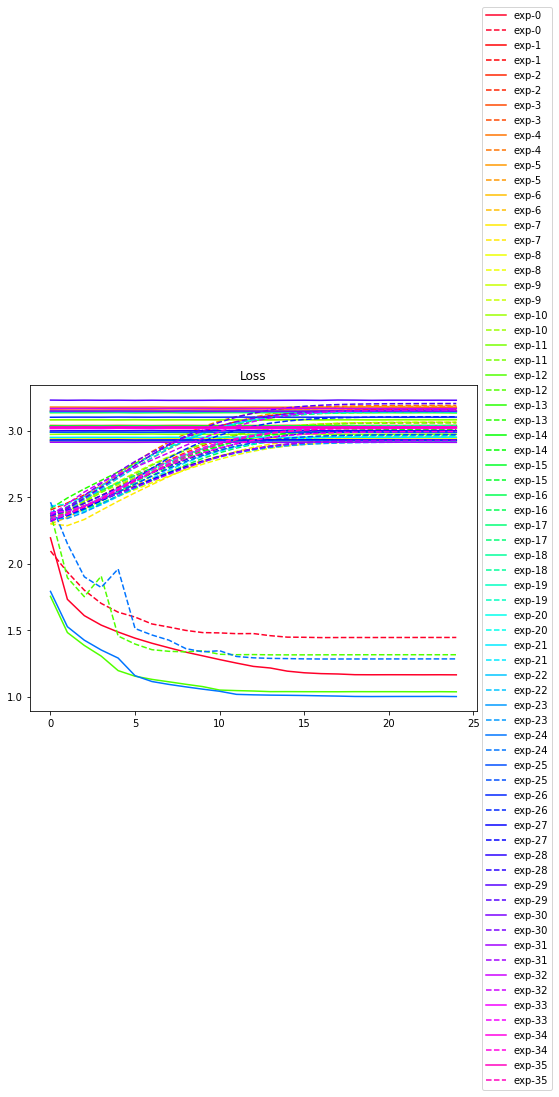

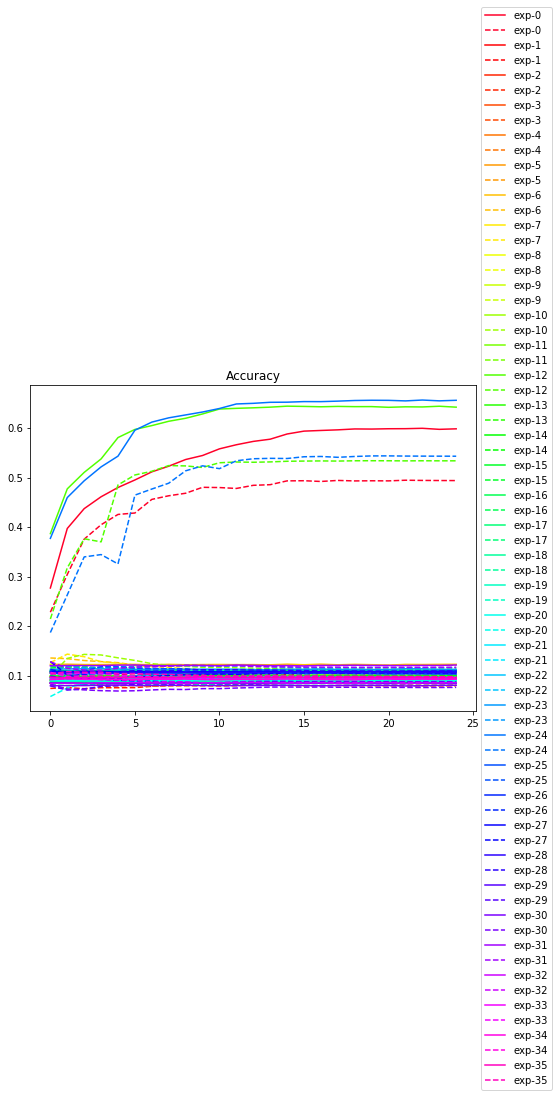

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()